# Advanced DL and RL: Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

In [39]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict

from tqdm import tqdm

In [40]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [5]:
# env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
# plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
def evaluate_strategy_based_on_Q(env, Q, player="crosses"):
    "Play episode in env with stategy based on Q vs random strategy"
    players = {
        "crosses": 1,
        "naughts": -1
    }
    env.reset()
    done = False
    while not done:
        if env.curTurn == players[player]:
            s, actions = env.getHash(), env.getEmptySpaces()
            a = actions[Q[s][tuple(actions.T)].argmax()]
            observation, reward, done, info = env.step(a)
        else:
            s, actions = env.getHash(), env.getEmptySpaces()
            a = actions[np.random.randint(0, len(actions))]
            observation, reward, done, info = env.step(a)
    return reward * players[player]

In [7]:
def Q_learning_episode(env, Q, alpha=0.05, epsilon=0.05, gamma=1.0):
    env.reset()
    done = False
    s_crosses, actions_crosses = env.getHash(), env.getEmptySpaces()
    a_crosses = (
        actions_crosses[Q[s_crosses][tuple(actions_crosses.T)].argmax()] if np.random.rand() > epsilon
        else actions_crosses[np.random.randint(0, len(actions_crosses))]
    )
    observation, reward, done, info = env.step(a_crosses)
    
    s_naughts, actions_naughts, _ = observation
    a_naughts = (
        actions_naughts[Q[s_naughts][tuple(actions_naughts.T)].argmax()] if np.random.rand() > epsilon
        else actions_naughts[np.random.randint(0, len(actions_naughts))]
    )

    while not done:
        if env.curTurn == 1:
            observation, reward, done, info = env.step(a_crosses)
            
            if reward == 1:
                Q[s_crosses][tuple(a_crosses)] = reward
            
            s_naughts_prime, actions_naughts, _ = observation
            
            if actions_naughts.any():
                a_naughts_prime = (
                    actions_naughts[Q[s_naughts_prime][tuple(actions_naughts.T)].argmax()]
                    if np.random.rand() > epsilon
                    else actions_naughts[np.random.randint(0, len(actions_naughts))]
                )
            
            Q[s_naughts][tuple(a_naughts)] = (
                Q[s_naughts][tuple(a_naughts)] +
                alpha * (
                    reward * -1 +
                    gamma * np.max( Q[s_naughts_prime] ) -
                    Q[s_naughts][tuple(a_naughts)]
                )
            )
                          
            s_naughts, a_naughts = s_naughts_prime, a_naughts_prime
                
        else:
            observation, reward, done, info = env.step(a_naughts)
            
            if reward == -1:
                Q[s_naughts][tuple(a_naughts)] = reward * -1
                
            s_crosses_prime, actions_crosses, _ = observation
            
            if actions_crosses.any():
                a_crosses_prime = (
                    actions_crosses[Q[s_crosses_prime][tuple(actions_crosses.T)].argmax()]
                    if np.random.rand() > epsilon
                    else actions_crosses[np.random.randint(0, len(actions_crosses))]
                )
            
            Q[s_crosses][tuple(a_crosses)] = (
                Q[s_crosses][tuple(a_crosses)] +
                alpha * (
                    reward + gamma * np.max( Q[s_crosses_prime] ) -
                    Q[s_crosses][tuple(a_crosses)]
                )
            )
                          
            s_crosses, a_crosses = s_crosses_prime, a_crosses_prime

In [8]:
def train_Q_learning_model(
    env, alpha=0.05, epsilon=0.05, gamma=1.0,
    train_episodes_num=100_000, eval_episodes_num=10_000, eval_interval=5_000
):
    # оценки для Q (крестиков и ноликов) храним в одной таблице, т.к. они не пересекаются по состояниям
    Q = defaultdict(lambda: np.zeros((N_ROWS, N_COLS)))
    
    avg_crosses_rewards = []
    avg_naughts_rewards = []
    episodes = []

    t_train_episodes_num = tqdm(range(1, train_episodes_num + 1))

    for i in t_train_episodes_num:
        Q_learning_episode(env, Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        
        if not i % eval_interval:
            crosses_rewards = np.array([
                evaluate_strategy_based_on_Q(env, Q, player="crosses")
                for i in range(eval_episodes_num)
            ])
            naughts_rewards = np.array([
                evaluate_strategy_based_on_Q(env, Q, player="naughts")
                for i in range(eval_episodes_num)
            ])
            avg_crosses_reward = crosses_rewards.mean()
            avg_naughts_reward = naughts_rewards.mean()
            avg_crosses_rewards.append(avg_crosses_reward)
            avg_naughts_rewards.append(avg_naughts_reward)
            episodes.append(i)
            t_train_episodes_num.set_postfix(
                avg_crosses_reward=avg_crosses_reward,
                avg_naughts_reward=avg_naughts_reward
            )

    avg_crosses_rewards = np.array(avg_crosses_rewards)
    avg_naughts_rewards = np.array(avg_naughts_rewards)
    episodes = np.array(episodes)
    
    return avg_crosses_rewards, avg_naughts_rewards, episodes, Q

In [9]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

alpha = 0.01
epsilon = 0.5
gamma = 1.0
        
avg_crosses_rewards_3x3, avg_naughts_rewards_3x3, episodes_3x3, Q_3x3 = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma
)

100%|██████████| 100000/100000 [03:12<00:00, 519.90it/s, avg_crosses_reward=0.996, avg_naughts_reward=0.86] 


Пробовал оценивать, как играеть стратегия, обученная играть против самой себя, но не очень информативно получилось, играет почти сразу в ноль. Да и нужно при этом подумать, как сэмплить при этом действия, чтобы не играть каждый раз одну и ту же партию.

Поэтому оцениваю против случайной стратегии:

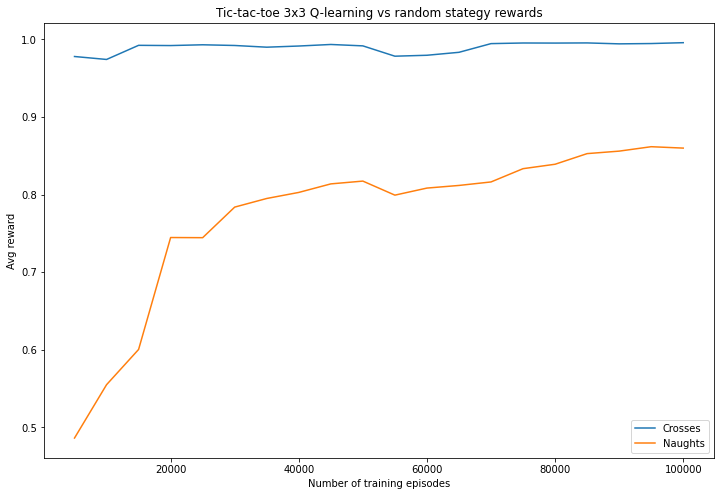

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(episodes_3x3, avg_crosses_rewards_3x3, label="Crosses")
plt.plot(episodes_3x3, avg_naughts_rewards_3x3, label="Naughts")
plt.legend()
plt.title('Tic-tac-toe 3x3 Q-learning vs random stategy rewards')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [11]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

alpha = 0.01
epsilon = 0.5
gamma = 1.0
        
avg_crosses_rewards_4x4, avg_naughts_rewards_4x4, episodes_4x4, Q_4x4 = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=200_000
)

100%|██████████| 200000/200000 [15:08<00:00, 220.10it/s, avg_crosses_reward=0.693, avg_naughts_reward=0.434]  


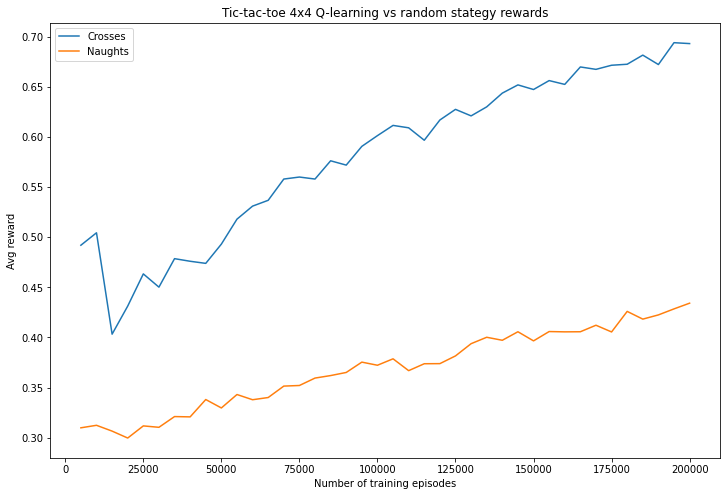

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(episodes_4x4, avg_crosses_rewards_4x4, label="Crosses")
plt.plot(episodes_4x4, avg_naughts_rewards_4x4, label="Naughts")
plt.legend()
plt.title('Tic-tac-toe 4x4 Q-learning vs random stategy rewards')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

С возросшим числом возможных состояний сходится намного дольше.

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [10]:
import math
import random

import torch

from datetime import datetime

from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms.functional import to_tensor

In [71]:
class TicTacToeDQN():
    def __init__(self, n_rows=4, n_cols=4, n_win=4):
        self.env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 1, 3, padding=1),
            nn.Flatten(1)
        )
        
        self.memory = ReplayMemory(2_000_000)
        self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-4)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 1.0
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200_000
        self.num_step = 0
        self.eval_interval = 100
        self.eval_episodes_num = 1000
        self.avg_crosses_rewards = []
        self.avg_naughts_rewards = []
        

    def select_greedy_action(self, state):
        actions = self.model(state.reshape(1, *state.shape)).data
        action = actions.max(1)[1].view(1, 1)
        
        return self.model(state.reshape(1, *state.shape)).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(16)]], dtype=torch.int64)
        
    def get_action(self, state_tensor, greedy=False):
        with torch.no_grad():
            if greedy:
                a = self.select_greedy_action(state_tensor)
            else:
                a = self.select_action(state_tensor)
        return a
        
    def save_transition(self, state_tensor, action, next_state_tensor, reward):
        transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
        self.memory.store(transition)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        done = False
        
        s_crosses, actions_crosses = to_tensor(self.env.board).reshape(
            1, self.env.n_rows, self.env.n_cols
        ).float(), self.env.getEmptySpaces()
        
        a_crosses_idx = self.get_action(s_crosses, greedy)
#         a_crosses = actions_crosses[a_crosses_idx]
        a_crosses = self.env.action_from_int(a_crosses_idx)

        observation, reward, done, info = self.env.step(actions_crosses[a_crosses_idx])
        
        s_naughts, actions_naughts = to_tensor(self.env.board).reshape(
            1, self.env.n_rows, self.env.n_cols
        ).float(), observation[1]
        a_naughts_idx = self.get_action(s_naughts, greedy)
#         a_naughts = actions_naughts[a_naughts_idx]
        a_naughts = self.env.action_from_int(a_naughts_idx)
        s_crosses_prime, s_naughts_prime = None, None

        while not done:
            if self.env.curTurn == 1:
                observation, reward, done, info = self.env.step(a_crosses)

#                 if reward == 1:
#                     Q[s_crosses][tuple(a_crosses)] = reward

                s_naughts_prime, actions_naughts = to_tensor(self.env.board).reshape(
                    1, self.env.n_rows, self.env.n_cols
                ).float(), observation[1]

                if actions_naughts.any():
                    a_naughts_prime_idx = self.get_action(s_naughts_prime, greedy)
                    a_naughts_prime = self.env.action_from_int(a_naughts_prime_idx)
        
                if reward == -10:
                    self.save_transition(s_crosses, a_crosses_idx, s_naughts_prime, reward)
                elif reward == 1:
                    self.save_transition(s_crosses, a_crosses_idx, s_naughts_prime, reward)
                else:
                    self.save_transition(s_naughts, a_naughts_idx, s_naughts_prime, reward if reward == -10 else reward * -1)

                s_naughts, a_naughts, a_naughts_idx = s_naughts_prime, a_naughts_prime, a_naughts_prime_idx

            else:
                observation, reward, done, info = self.env.step(a_naughts)

#                 if reward == -1:
#                     Q[s_naughts][tuple(a_naughts)] = reward * -1

                s_crosses_prime, actions_crosses = to_tensor(self.env.board).reshape(
                    1, self.env.n_rows, self.env.n_cols
                ).float(), observation[1]

                if actions_crosses.any():
                    a_crosses_prime_idx = self.get_action(s_crosses_prime, greedy)
                    a_crosses_prime = self.env.action_from_int(a_crosses_prime_idx)
                
                if reward == -10:
                    self.save_transition(s_naughts, a_naughts_idx, s_crosses_prime, reward)
                elif reward == -1:
                    self.save_transition(s_naughts, a_naughts_idx, s_crosses_prime, reward)
                else:
                    self.save_transition(s_crosses, a_crosses_idx, s_crosses_prime, reward)

                s_crosses, a_crosses, a_crosses_idx = s_crosses_prime, a_crosses_prime, a_crosses_prime_idx
    
            if do_learning:
                self.learn()
            
        if not e % self.eval_interval:
            crosses_rewards = np.array([
                self.evaluate_strategy(player="crosses")
                for i in range(self.eval_episodes_num)
            ])
            naughts_rewards = np.array([
                self.evaluate_strategy(player="naughts")
                for i in range(self.eval_episodes_num)
            ])
            avg_crosses_reward = crosses_rewards.mean()
            avg_naughts_reward = naughts_rewards.mean()
            self.avg_crosses_rewards.append(avg_crosses_reward)
            self.avg_naughts_rewards.append(avg_naughts_reward)
            print(f"e = {e}\t avg_crosses_reward = {avg_crosses_reward}\t avg_naughts_rewards = {avg_naughts_reward}")


    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state.unsqueeze(1)).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state.unsqueeze(1)).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def evaluate_strategy(self, player="crosses", greedy=True):
        players = {
            "crosses": 1,
            "naughts": -1
        }
        self.env.reset()
        
        done = False
        while not done:
            if self.env.curTurn == players[player]:
                
                s = to_tensor(self.env.board).reshape(
                    1, self.env.n_rows, self.env.n_cols
                ).float()
                a_idx = self.get_action(s, greedy)
                a = self.env.action_from_int(a_idx)
                
                observation, reward, done, info = self.env.step(a)
            else:
                s, actions = self.env.getHash(), self.env.getEmptySpaces()
                a = actions[np.random.randint(0, len(actions))]
                observation, reward, done, info = self.env.step(a)
        return reward * players[player] if reward != -10 else reward

In [72]:
dqn = TicTacToeDQN()

n_episodes = 50000

print(f"{datetime.now().time()}\tStarting training for {n_episodes} episodes...")
for e in range(n_episodes):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

00:46:34.192140	Starting training for 50000 episodes...
e = 0	 avg_crosses_reward = -9.955	 avg_naughts_rewards = -9.884
e = 100	 avg_crosses_reward = -9.9	 avg_naughts_rewards = -9.928
e = 200	 avg_crosses_reward = -9.863	 avg_naughts_rewards = -9.928
e = 300	 avg_crosses_reward = -9.81	 avg_naughts_rewards = -9.906
e = 400	 avg_crosses_reward = -9.873	 avg_naughts_rewards = -9.798
e = 500	 avg_crosses_reward = -9.781	 avg_naughts_rewards = -9.778
e = 600	 avg_crosses_reward = -9.725	 avg_naughts_rewards = -9.785
e = 700	 avg_crosses_reward = -9.794	 avg_naughts_rewards = -9.541
e = 800	 avg_crosses_reward = -9.829	 avg_naughts_rewards = -9.658
e = 900	 avg_crosses_reward = -9.555	 avg_naughts_rewards = -9.623
e = 1000	 avg_crosses_reward = -9.668	 avg_naughts_rewards = -9.663
e = 1100	 avg_crosses_reward = -9.469	 avg_naughts_rewards = -9.543
e = 1200	 avg_crosses_reward = -9.373	 avg_naughts_rewards = -9.638
e = 1300	 avg_crosses_reward = -9.292	 avg_naughts_rewards = -9.547
e = 140

KeyboardInterrupt: 

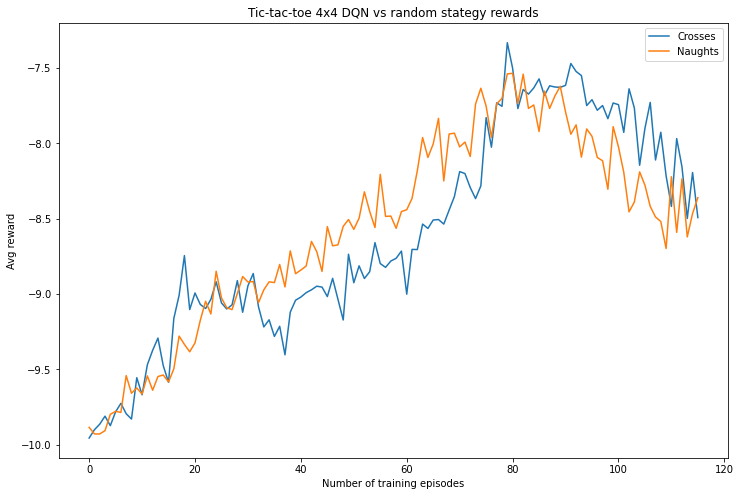

In [73]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(dqn.avg_crosses_rewards)), dqn.avg_crosses_rewards, label="Crosses")
plt.plot(np.arange(len(dqn.avg_naughts_rewards)), dqn.avg_naughts_rewards, label="Naughts")
plt.legend()
plt.title('Tic-tac-toe 4x4 DQN vs random stategy rewards')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

Видно, что сеть обучается.

Но, подозреваю, что было плохой идеей обучать одну сеть и для крестиков, и для ноликов.